# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 10


# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

In [8]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

## Handling IID data

In [10]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  5000
There is 10 devices.
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000
Number of points on this device: 5000


In [11]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.495
ratio of state 1 on this device:  0.4904
ratio of state 1 on this device:  0.5066
ratio of state 1 on this device:  0.4892
ratio of state 1 on this device:  0.5108
ratio of state 1 on this device:  0.4884
ratio of state 1 on this device:  0.5016
ratio of state 1 on this device:  0.4962
ratio of state 1 on this device:  0.4932
ratio of state 1 on this device:  0.5008


In [12]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [13]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                               ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-iid-obj_min")

   it    |   obj   
   10000 | 5.4297e-01
   20000 | 5.4297e-01
   30000 | 5.4297e-01
   40000 | 5.4297e-01
Gradient Descent: execution time=566.156 seconds
Final loss : 0.54297

CPU times: user 33min 29s, sys: 21.4 s, total: 33min 51s
Wall time: 9min 26s


In [13]:
pickle_saver(obj_min, filename + "-iid-obj_min")

In [14]:
def ratio_failure(index: int, guess: int = 1):
    x = X[index]
    y = Y[index]
    w = obj_min_by_N_descent.model_params[-1]
    mul =  x.mv(w)
    inf_middle = 0
    failure = 0
    for i in range(len(mul)):
        if guess == 1:
            if torch.sigmoid(mul[i]) >= 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
        else:
            if torch.sigmoid(mul[i]) < 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
    print("Number of labels equal to " + str(guess) + ": ", inf_middle)
    print("Failures:", failure)
    print("Percent of labels wrongly predicted to be state " + str(guess) +" for worker 0: " + 
          str(failure/inf_middle * 100) + "%")
    
ratio_failure(1, 1)
ratio_failure(0, 1)

Number of labels equal to 1:  12198
Failures: 3533
Percent of labels wrongly predicted to be state 1 for worker 0: 28.96376455156583%
Number of labels equal to 1:  12211
Failures: 3484
Percent of labels wrongly predicted to be state 1 for worker 0: 28.531651789370237%


In [15]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [01:09<04:39, 69.98s/it]

QSGD


 40%|████      | 2/5 [02:19<03:29, 69.85s/it]

Diana


 60%|██████    | 3/5 [03:32<02:21, 70.80s/it]

BiQSGD


 80%|████████  | 4/5 [04:55<01:14, 74.42s/it]

Artemis


100%|██████████| 5/5 [06:20<00:00, 76.13s/it]

CPU times: user 6min 27s, sys: 189 ms, total: 6min 27s
Wall time: 6min 20s


In [16]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.0450,  0.0013,  0.0213, -0.0332,  0.5562, -0.0364,  0.0063, -0.0354,
         0.2686,  0.0305,  0.0082,  0.0248, -0.0656,  0.9843,  0.3945,  0.1731,
        -0.0067, -0.0327, -0.0329, -0.0143,  0.0329,  0.0115, -0.0250,  0.0231,
         0.0082, -0.0122,  0.0294, -0.1682,  0.0221,  0.0017,  0.0157,  0.0226,
         0.0048, -0.0192, -0.0065, -0.0107, -0.0607, -0.0468,  0.0794, -0.0253,
         0.0032,  0.0136, -0.0272, -0.1230,  0.0135,  0.0343,  0.0017, -0.0236,
         0.0064,  0.0347,  0.0948, -0.0154, -0.0358,  0.2143, -0.0259,  0.0223,
        -0.1226,  0.0409,  0.3312, -0.0216,  0.0372, -0.0103, -0.4883, -0.0110,
         0.0343, -0.0357], dtype=torch.float64)


### With averaging

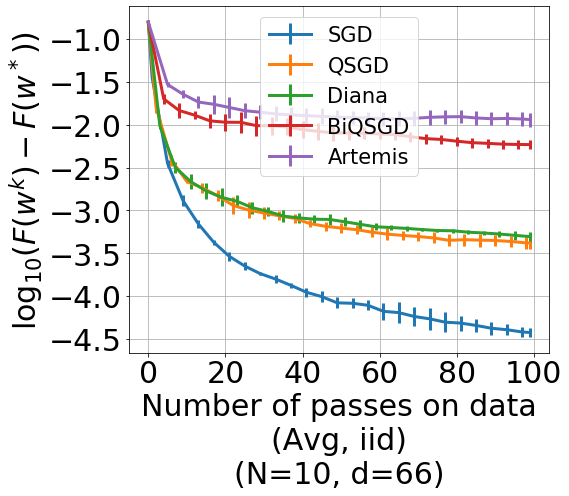

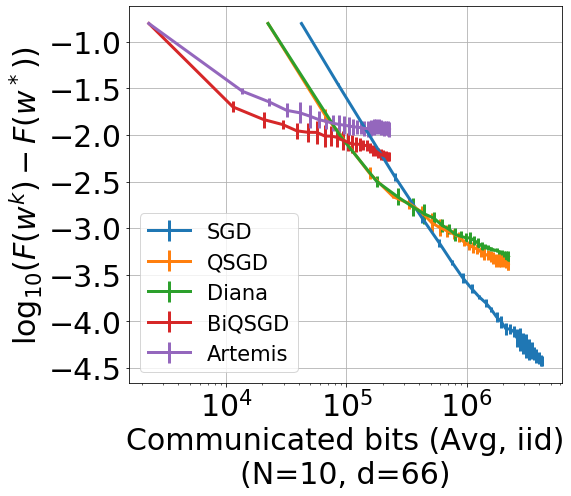

In [14]:
obj = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


### Without averaging

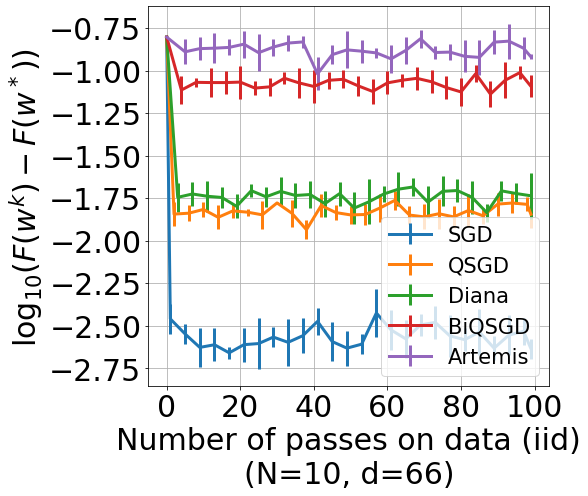

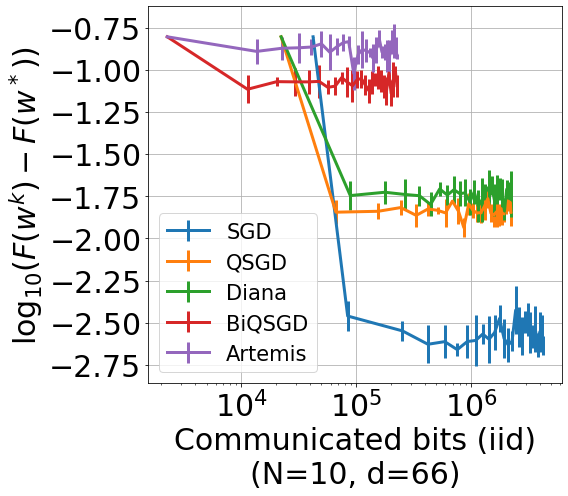

In [15]:
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

There is 10 devices.
Number of points on device 0 : 8531
Number of points on device 1 : 1175
Number of points on device 2 : 5122
Number of points on device 3 : 2045
Number of points on device 4 : 4255
Number of points on device 5 : 1322
Number of points on device 6 : 3869
Number of points on device 7 : 2425
Number of points on device 8 : 9669
Number of points on device 9 : 11587
CPU times: user 3min 29s, sys: 1.87 s, total: 3min 31s
Wall time: 53 s


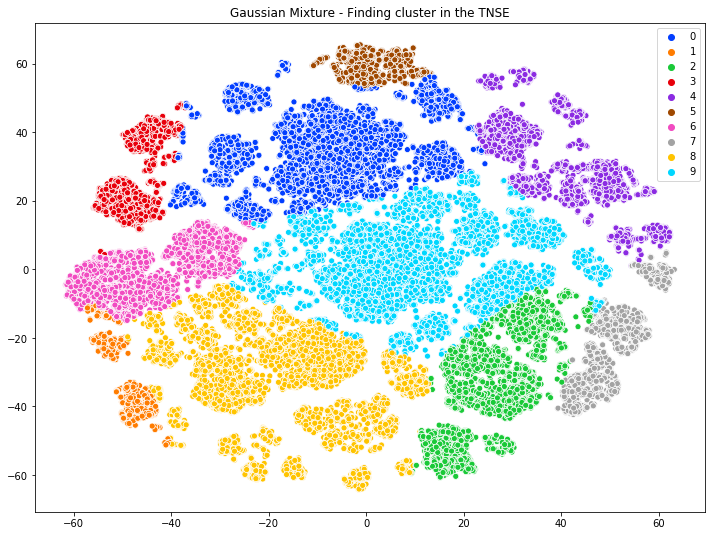

In [9]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader(filename + "-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

In [24]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4399100812726958
ratio of state 1 on this device:  0.6140708641345909
ratio of state 1 on this device:  0.44875091844232184
ratio of state 1 on this device:  0.4655075715086932
ratio of state 1 on this device:  0.4658085277554304
ratio of state 1 on this device:  0.7321235102925244
ratio of state 1 on this device:  0.396870925684485
ratio of state 1 on this device:  0.40108134676824775
ratio of state 1 on this device:  0.5354200988467874
ratio of state 1 on this device:  0.6057505732933498


In [23]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [24]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 5.2154e-01
   20000 | 5.2154e-01
   30000 | 5.2154e-01
   40000 | 5.2154e-01
Gradient Descent: execution time=473.901 seconds
Final loss : 0.52154

CPU times: user 30min 2s, sys: 13.7 s, total: 30min 15s
Wall time: 7min 53s


## Batch size $= 1$ (stochastic)

In [23]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, stochastic=True, 
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

QSGD


 40%|████      | 2/5 [00:10<00:14,  4.78s/it]

Diana


 60%|██████    | 3/5 [00:17<00:10,  5.34s/it]

BiQSGD


 80%|████████  | 4/5 [00:26<00:06,  6.55s/it]

Artemis


100%|██████████| 5/5 [00:34<00:00,  6.94s/it]

CPU times: user 41.8 s, sys: 140 ms, total: 41.9 s
Wall time: 34.7 s


### With averaging

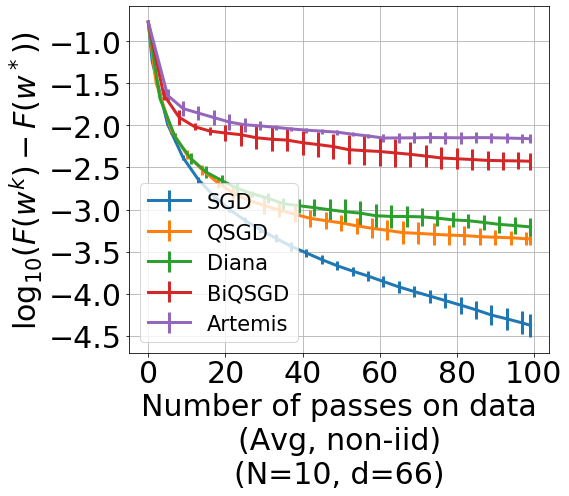

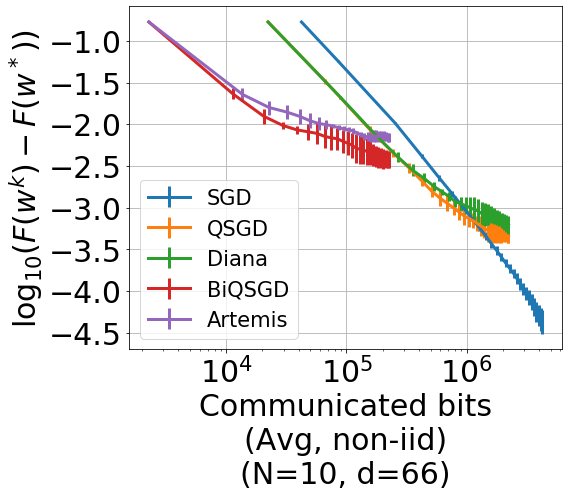

In [35]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min") + 0.0149 
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

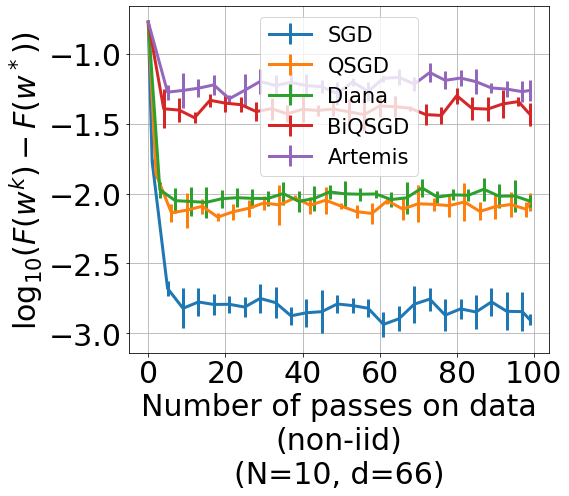

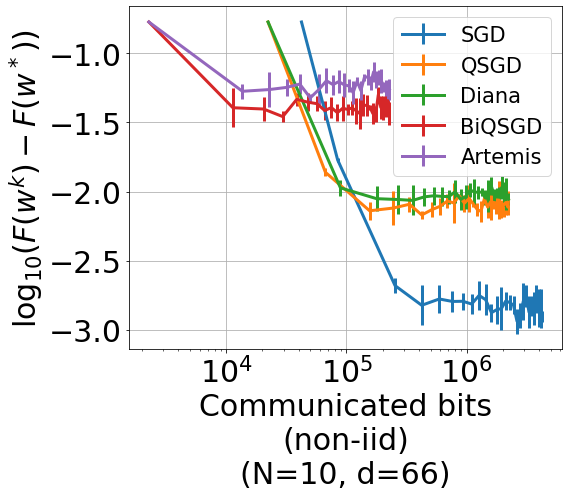

In [37]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min") + 0.0149 
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 800$

In [30]:
%%time
batch_size = 800
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               nb_epoch=500, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-800")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [01:38<06:34, 98.54s/it]

QSGD


 40%|████      | 2/5 [03:21<04:59, 99.82s/it]

Diana


 60%|██████    | 3/5 [05:03<03:21, 100.67s/it]

BiQSGD


 80%|████████  | 4/5 [06:47<01:41, 101.51s/it]

Artemis


100%|██████████| 5/5 [08:30<00:00, 102.17s/it]

CPU times: user 33min 45s, sys: 16.2 s, total: 34min 1s
Wall time: 8min 30s


### With averaging

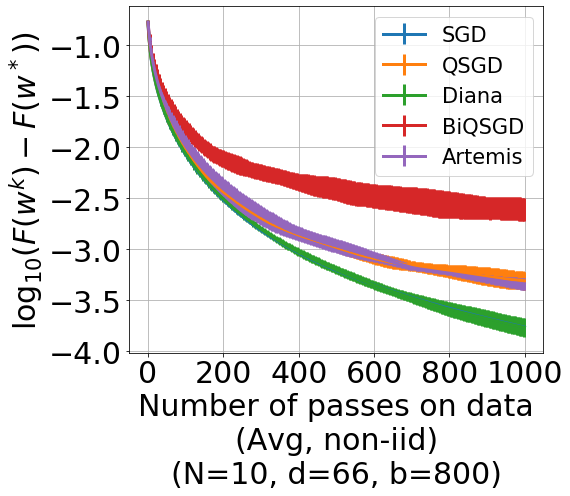

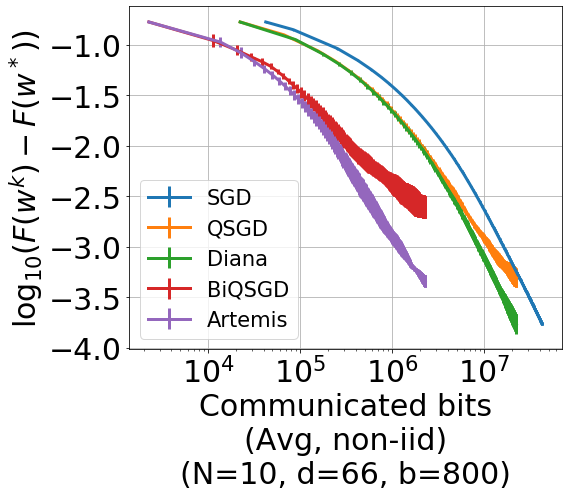

In [42]:
batch_size = 800
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min") + 0.0149 
res = pickle_loader(filename + "-noniid-descent-800")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

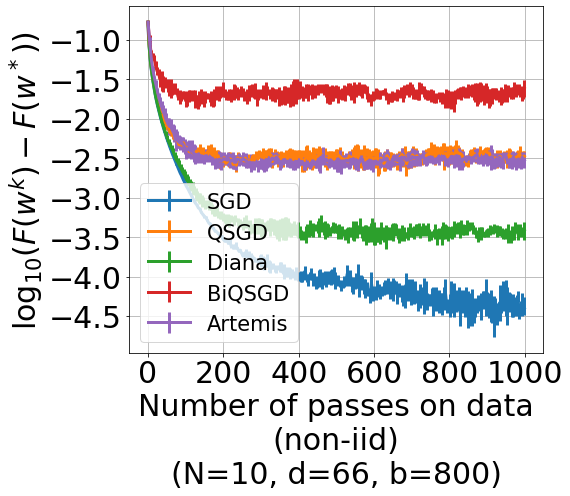

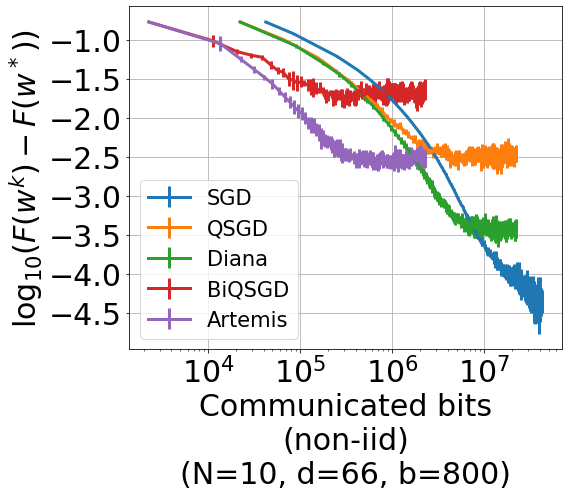

In [39]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min") + 0.0149 
res = pickle_loader(filename + "-noniid-descent-800")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 